In [1]:
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## Clustering on customers data

**Clustering customers based on their behavior** or other characteristics is a crucial aspect that allows a business to know their market, better tailor marketing efforts, and improve product development strategies. Let's look at the data set containing wholesale customers purchasing information that contains data about customers' annual spending on different products.

Let's load in the data we will be working with and inspect the first couple of rows.

In [2]:
import pandas as pd

df_wholesale = pd.read_csv('Wholesale_customers.csv')

In [7]:
df_wholesale.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,0,3,12669,9656,7561,214,2674,1338
1,0,3,7057,9810,9568,1762,3293,1776
2,0,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,0,3,22615,5410,7198,3915,1777,5185


In [8]:
df_wholesale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434 entries, 0 to 433
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           434 non-null    int64
 1   Region            434 non-null    int64
 2   Fresh             434 non-null    int64
 3   Milk              434 non-null    int64
 4   Grocery           434 non-null    int64
 5   Frozen            434 non-null    int64
 6   Detergents_Paper  434 non-null    int64
 7   Delicatessen      434 non-null    int64
dtypes: int64(8)
memory usage: 27.2 KB


The '`Channel`' describes whether a customer is a hotel/restaurant/cafe or not and '`Region`' describes where they are from. For the purpose of clustering our customers we will only focus on their spending habits, so we will only use  information about customers annual spending (reported in euros) on fresh products, milk products, grocery, frozen products, detergents and paper products, and delicatessen products.

In [9]:
df_spending = df_wholesale.iloc[:, 2:]
df_spending.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


We want to get a general idea of what kinds of customers we have in this data. To do so, our plan will be to organize this data into groups, such that customers in the same group are more similar to one another than they are to customers in other groups. Then, we might see, for instance, that one group tends to buy a lot of milk products and not many detergents and paper products. Based on these preferences, we can obtain some insight into defining characteristics of our customer base. 

Clustering is *not* classification. There are no true values we're trying to predict, and we don't know how many groups are appropriate to identify in the data. Instead, clustering gives us a set of methods for defining clusters and a set of metrics for evaluating how well those clusters partition the data, and it is left to us as data scientists to assess the clusters and find insights. 

Now we are ready to fit a K-Means model to our customers' data. Let's prepare the data before we feed it into the clustering algorithm. We will first filter out any outliers from the data. Outliers are not such a big problem in this data set, but the results will improve if we make this the first step.

In [10]:
import itertools
import numpy as np

def filter_outliers(df):
    outliers_list  = []

    for feature in df.columns:
        Q1 = np.percentile(df.loc[:, feature], 25)

        Q3 = np.percentile(df.loc[:, feature], 75)

        step = 1.5 * (Q3 - Q1)

        outliers_found = df.loc[~((df[feature] >= Q1 - step) & (df[feature] <= Q3 + step)), :]

        outliers_list.append(list(outliers_found.index))

    outliers = list(itertools.chain.from_iterable(outliers_list))
    
    uniq_outliers = list(set(outliers))

    dup_outliers = list(set([x for x in outliers if outliers.count(x) > 1]))

    filtered_df = df.drop(df.index[dup_outliers]).reset_index(drop = True)

    return filtered_df

In [11]:
df_spending_cleaned = filter_outliers(df_spending)

In [12]:
print('Number of rows before cleaning: {}'.format(df_spending.shape[0]))
print('Number of rows after cleaning: {}'.format(df_spending_cleaned.shape[0]))

Number of rows before cleaning: 434
Number of rows after cleaning: 397


### Scale your data

Remember that K-Means clustering uses the distance between points to define clusters. This means that all features should be scaled such that their units are comparable. Otherwise, certain features may seem artificially to have more variance than others. 

In the case of the customers data set, all our features (annual spending on different products) are measured in the same units, so it could actually happen that scaling the data in this case would mean losing important information. This is something we need to be careful about and check. In this particular case it turns out that whether we scale the data with scikit-learn's `StandardScaler` transformer or not doesn't impact the results very much. We will scale the data here nevertheless, but again this step is even more important when dealing with features that are using units that are not comparable (for example customer income and customer age).

We will scale the data with scikit-learn's `StandardScaler` transformer. As we know, it centers each feature around its mean and scales it by dividing by that feature's standard deviation. 

In [13]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()

df_spending_cleaned_scaled = pd.DataFrame(standard_scaler.fit_transform(df_spending_cleaned),
                                          columns=df_spending_cleaned.columns)
df_spending_cleaned_scaled.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,0.155679,1.504403,0.285557,-0.783649,0.238210,0.101340
1,-0.389173,1.547533,0.666579,-0.274419,0.470146,0.440277
2,-0.457522,1.266906,0.308908,-0.062897,0.553703,5.135868
3,0.213542,-0.864959,-0.348530,1.252616,-0.573752,0.449563
4,1.121304,0.315241,0.216643,0.433833,-0.097891,3.078258


### Dimensionality reduction

Clustering algorithms and metrics tend to be computationally complex, and this complexity scales very quickly with the number of features. As such, it is very common to reduce the dimensionality of the data before feeding into a K-Means clustering algorithm. 

In the previous lectures we talked about principal components analysis (PCA) as a method for reducing the number of features in data while retaining as much information as possible. While our customer data set does not have that many features we will still reduce the dimensionality before we proceed, if nothing else so that we can visualize the results.

Let's first perform PCA without throwing away any components, and plot the cumulative sum of the explained variance ratio so we can see how many components are required to explain a significant amount of the variation in the data.

[0.43819008 0.22495586 0.13055752 0.12127262 0.06282274 0.02220118]


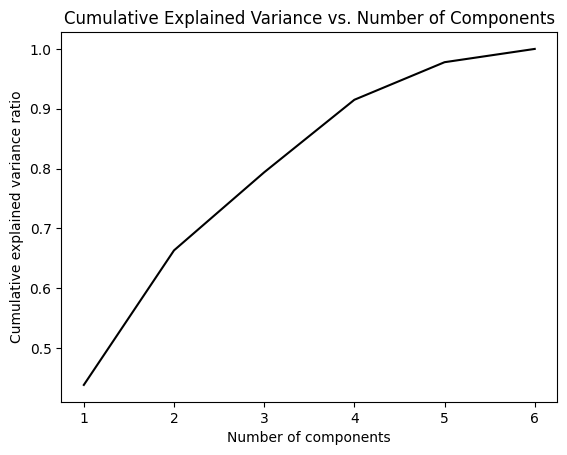

In [14]:
from sklearn.decomposition import PCA

pca = PCA(n_components=df_spending_cleaned_scaled.shape[1])

customers_pca_transformed = pca.fit_transform(df_spending_cleaned_scaled)
print(pca.explained_variance_ratio_)
plt.plot(range(1, df_spending_cleaned_scaled.shape[1]+1), pca.explained_variance_ratio_.cumsum(), 'k')
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance ratio")
plt.title("Cumulative Explained Variance vs. Number of Components");

It looks like we would need to use 4 components to capture 90% of the variance, but 3 components capture 80% and choosing 3 will lend itself to inspecting the results with a visualization. So let's use a 3 PC

In [15]:
pca3D = PCA(n_components=3)

customers_pca_3D = pca3D.fit_transform(df_spending_cleaned_scaled)

### Finding clusters

Now let's train a K-Means model on this data for a range of `n_clusters` values and compute the silhouette score for each model.

In [16]:
from sklearn.metrics import silhouette_score
scores=[]
for n_clusters in range(2, 9):
    km = KMeans(n_clusters=n_clusters)
    km.fit(customers_pca_3D)
    
    # Predict the cluster for each data point
    preds = km.predict(customers_pca_3D)

    # Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(customers_pca_3D, preds, metric='euclidean')
    scores.append(score)
    print('For n_clusters = {}, the average silhouette_score is : {}'
          .format(n_clusters, score.round(5)))

For n_clusters = 2, the average silhouette_score is : 0.4406
For n_clusters = 3, the average silhouette_score is : 0.4163
For n_clusters = 4, the average silhouette_score is : 0.43308
For n_clusters = 5, the average silhouette_score is : 0.38857
For n_clusters = 6, the average silhouette_score is : 0.37697
For n_clusters = 7, the average silhouette_score is : 0.37031
For n_clusters = 8, the average silhouette_score is : 0.35011


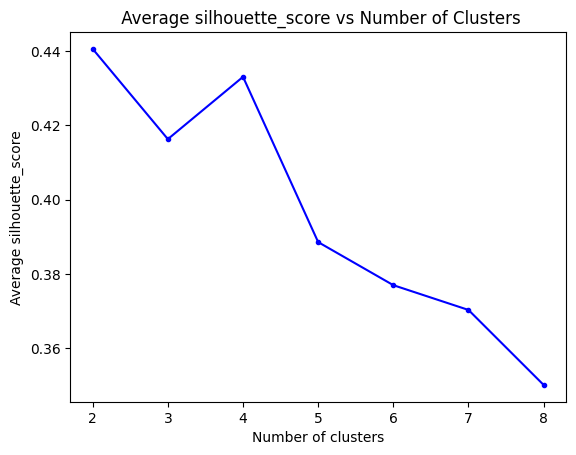

In [17]:
plt.plot(range(2,9), scores, c='b', marker='.')
plt.title(" Average silhouette_score vs Number of Clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Average silhouette_score");

For n_clusters = 2 The average silhouette_score is : 0.44059543746375046
For n_clusters = 3 The average silhouette_score is : 0.41758783895580465
For n_clusters = 4 The average silhouette_score is : 0.43723980084744785
For n_clusters = 5 The average silhouette_score is : 0.38857284810479253
For n_clusters = 6 The average silhouette_score is : 0.3599744188045856


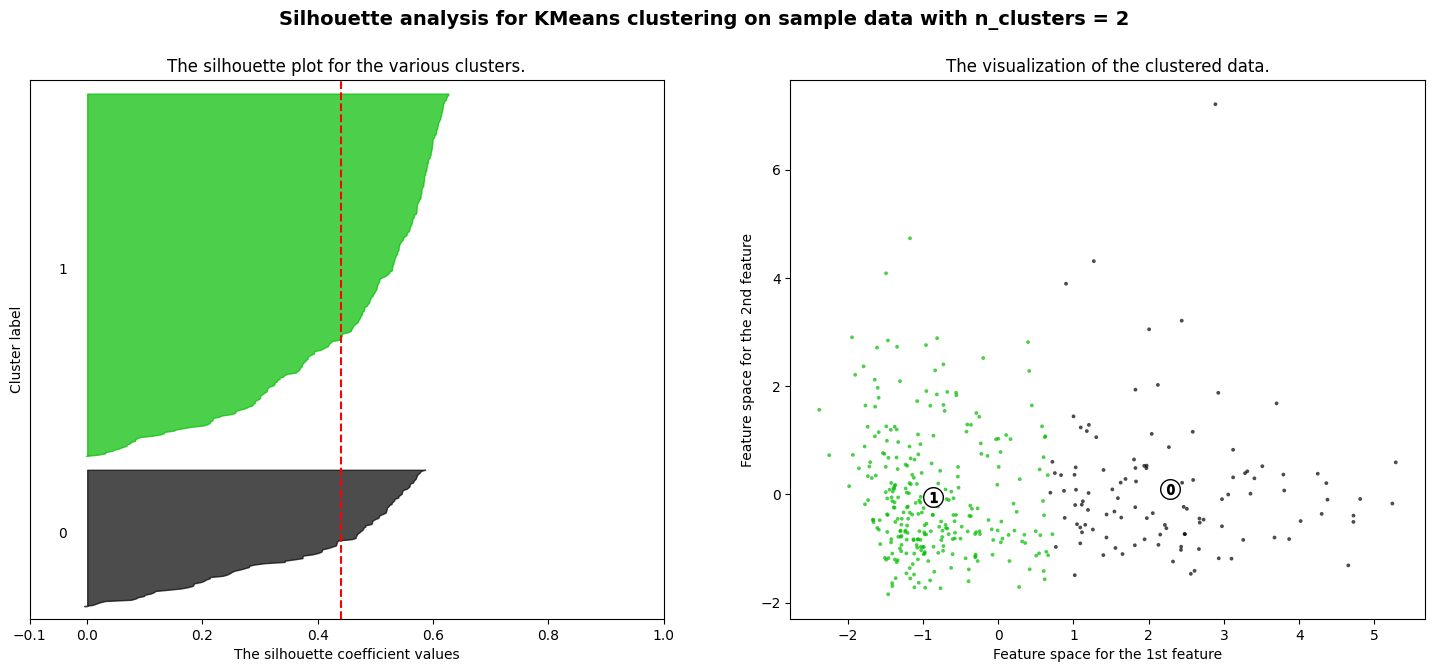

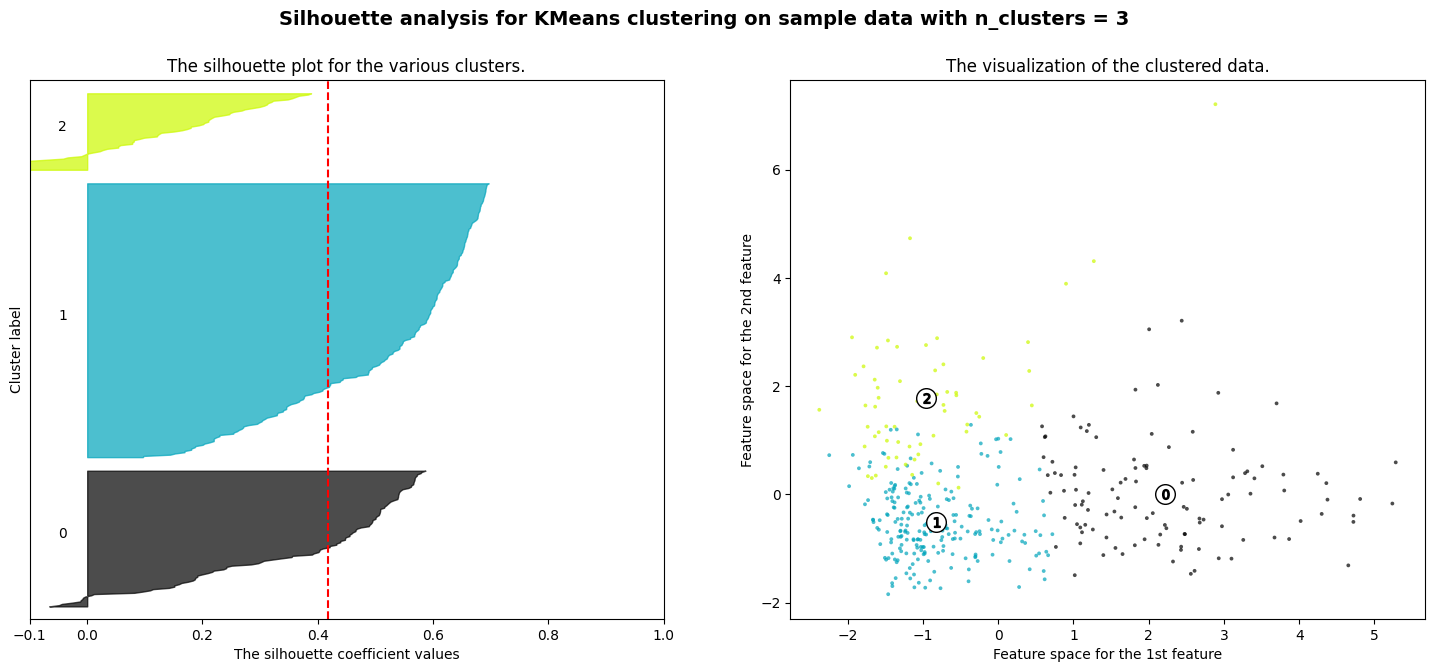

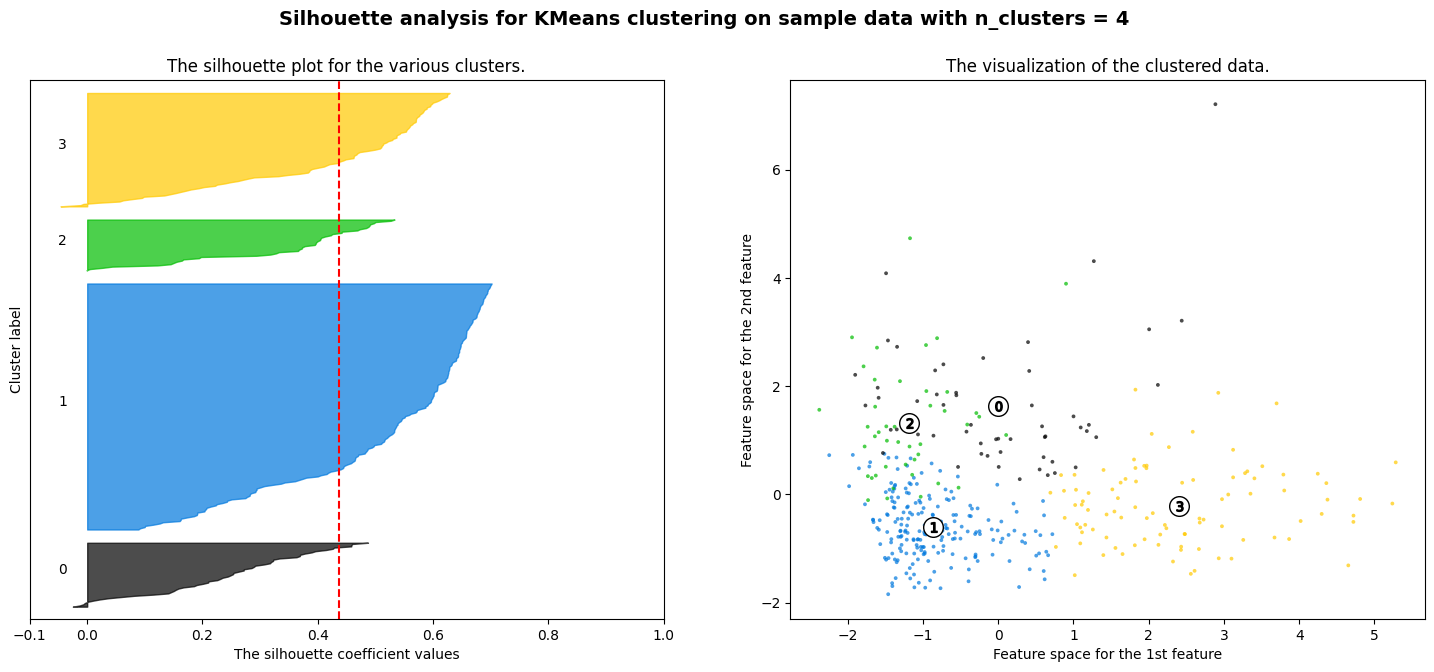

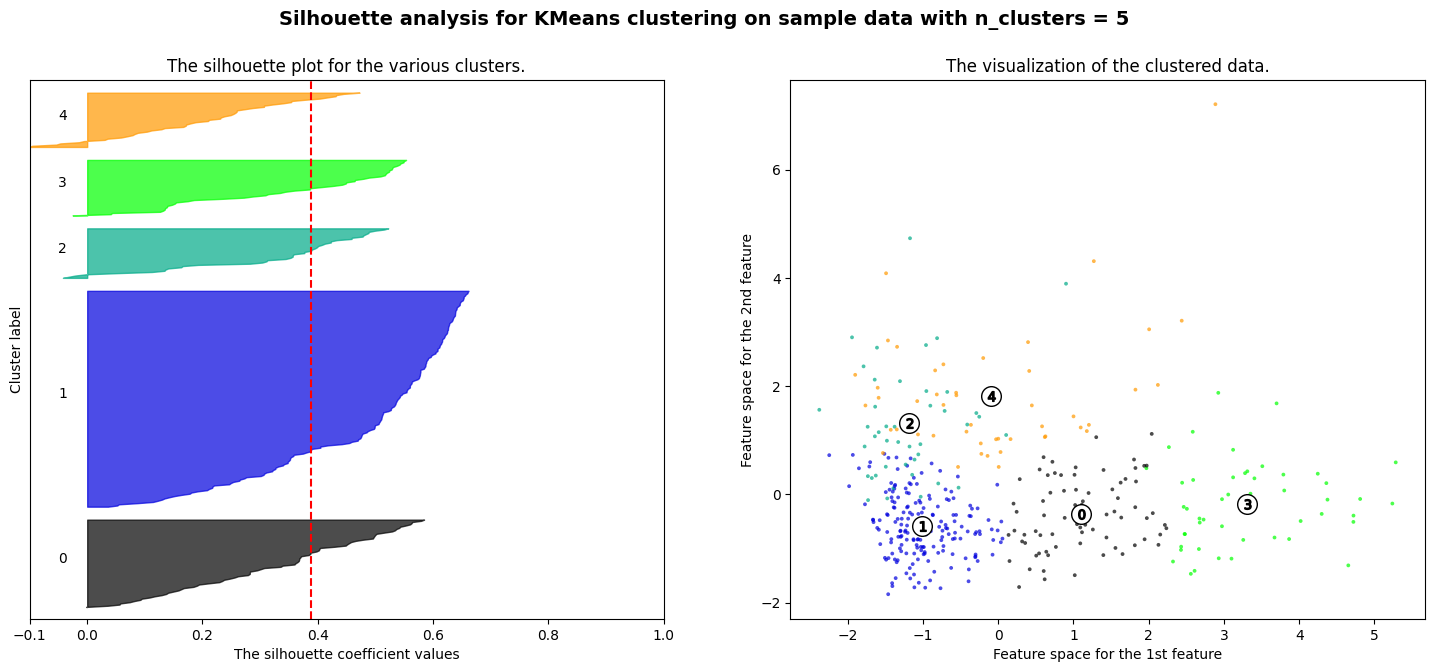

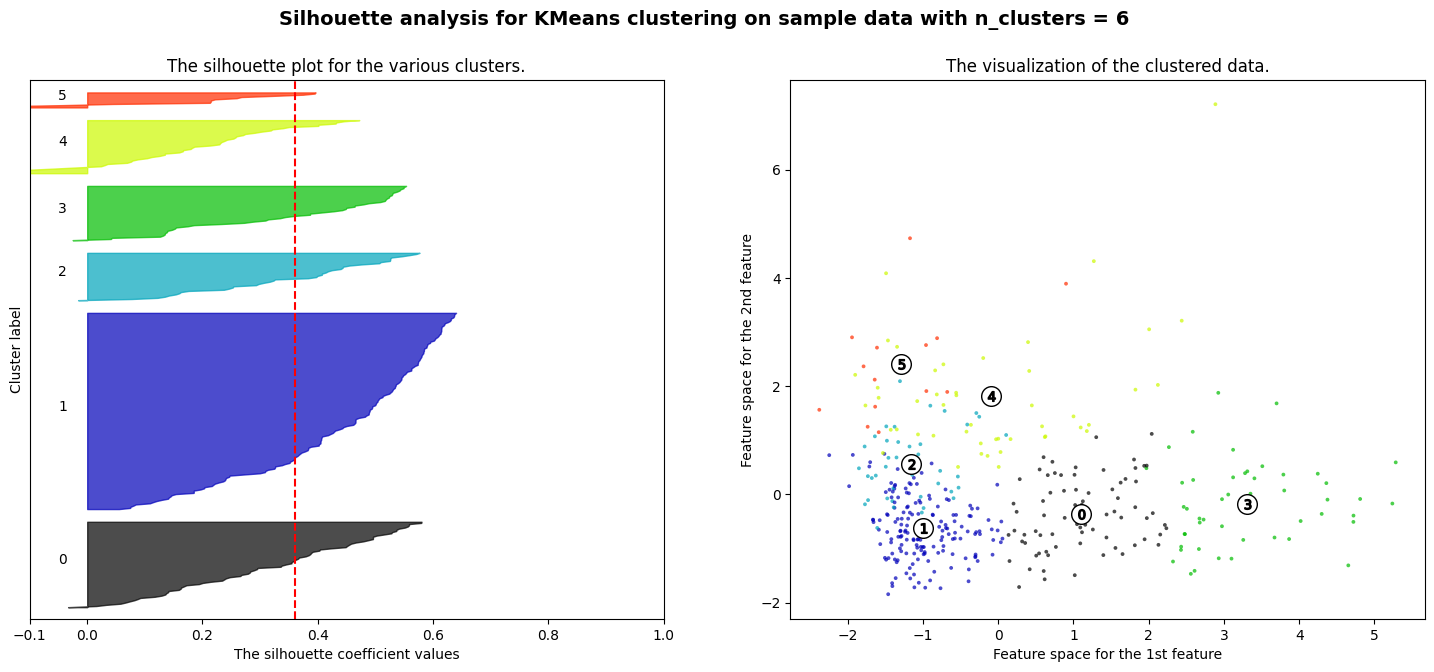

In [18]:
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, axes = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    axes[0].set_xlim([-.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    axes[0].set_ylim([0, len(customers_pca_3D) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
    pred_cluster_labels = clusterer.fit_predict(customers_pca_3D)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(customers_pca_3D, pred_cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(customers_pca_3D, pred_cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[pred_cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        axes[0].fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        axes[0].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    axes[0].set_title("The silhouette plot for the various clusters.")
    axes[0].set_xlabel("The silhouette coefficient values")
    axes[0].set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    axes[0].axvline(x=silhouette_avg, color="red", linestyle="--")

    axes[0].set_yticks([])  # Clear the yaxis labels / ticks
    axes[0].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(pred_cluster_labels.astype(float) / n_clusters)
    axes[1].scatter(
        customers_pca_3D[:, 0], customers_pca_3D[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    axes[1].scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        axes[1].scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    axes[1].set_title("The visualization of the clustered data.")
    axes[1].set_xlabel("Feature space for the 1st feature")
    axes[1].set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

It looks like there are probably 2 clusters in the data, but we could also choose 4. Let's see what we get for 4 clusters. We will visualize the results of a K-Means clustering model with 4 clusters by plotting the 3D data we obtained after the PCA transformation and color each data point according to the cluster it belongs to. The plot below will have two sliders, play around with them to observe the data from different angles.

In [41]:
cols

array([0, 0, 2, 3, 2, 1, 1, 0, 1, 0, 0, 1, 2, 0, 0, 1, 0, 2, 2, 1, 2, 1,
       2, 1, 1, 1, 2, 2, 1, 1, 2, 1, 0, 2, 0, 0, 2, 0, 0, 0, 0, 1, 1, 2,
       0, 2, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 3, 1, 3, 2, 3, 3, 0, 1, 3, 1,
       1, 1, 0, 0, 1, 1, 3, 2, 1, 3, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 3, 2, 1, 2, 3,
       1, 1, 1, 1, 1, 0, 1, 2, 1, 2, 2, 2, 3, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 2, 2,
       1, 1, 2, 0, 1, 1, 1, 0, 0, 0, 3, 1, 1, 0, 1, 3, 3, 0, 1, 1, 2, 1,
       1, 0, 1, 1, 1, 0, 2, 1, 0, 0, 0, 1, 0, 1, 1, 0, 3, 1, 1, 1, 2, 1,
       1, 3, 3, 1, 1, 1, 2, 1, 1, 1, 1, 2, 3, 1, 1, 2, 0, 0, 1, 1, 1, 3,
       1, 3, 2, 0, 1, 1, 1, 2, 2, 1, 3, 1, 1, 0, 0, 2, 0, 1, 1, 1, 1, 2,
       1, 1, 2, 3, 3, 2, 1, 2, 2, 3, 2, 1, 3, 1, 2, 1, 1, 1, 0, 2, 1, 1,
       1, 0, 1, 2, 0, 0, 0, 0, 0, 1, 1, 0, 3, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 3, 1, 1, 2, 3, 2, 1, 3, 3,

In [40]:
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import *
from ipywidgets import IntSlider
from ipywidgets import widgets, interactive

n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, n_init=10)
kmeans.fit(customers_pca_3D)

cols = kmeans.predict(customers_pca_3D)
colors = ['#ba2121ff', '#42a5f5ff', '#efa016ff', '#000000ff']
centroids = kmeans.cluster_centers_


def plot_rotate(az, el):
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(111, projection='3d')

    ax.view_init(elev=el, azim=az)

    x = customers_pca_3D[:,0]
    y = customers_pca_3D[:,1]
    z = customers_pca_3D[:,2]
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    ax.set_zlabel('PC 3', rotation=90, labelpad=-2)

    ax.scatter(x, y, z, marker='o', s=4, color=[colors[col] for col in cols])

interact(plot_rotate, az=IntSlider(min=0, max=300, step=10, value=50, description='azimith'), 
                      el=IntSlider(min=0, max=90, step=10, value=20, description='elevation'));

interactive(children=(IntSlider(value=50, description='azimith', max=300, step=10), IntSlider(value=20, descri…

### Interpreting cluster centroids

We found 4 clusters and each cluster has a centroid which corresponds to the average customer of that cluster. Because we scaled our data and used PCA on it before we fed it into a K-Means model, we need to apply inverse transformations to recover average customer information.

In [24]:
# Invert PCA
scaled_centers = pca3D.inverse_transform(centroids)

# Invert standard scaler
true_centers = standard_scaler.inverse_transform(scaled_centers)

In [25]:
typical_customers_scaled = pd.DataFrame(scaled_centers, columns=df_spending.columns, 
                                 index=['typical customer 1', 'typical customer 2', 
                                        'typical customer 3', 'typical customer 4'])
typical_customers_scaled

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
typical customer 1,-0.650961,1.210938,1.378033,-0.413778,1.393946,0.182482
typical customer 2,1.336974,0.108084,0.006676,-0.092992,-0.289978,1.243924
typical customer 3,-0.156002,-0.550237,-0.557167,-0.279787,-0.448882,-0.480278
typical customer 4,0.248358,-0.254048,-0.443400,2.331286,-0.558482,0.059130


In [26]:
typical_customers = pd.DataFrame(true_centers, columns=df_spending.columns, 
                                 index=['typical customer 1', 'typical customer 2', 
                                        'typical customer 3', 'typical customer 4'])
typical_customers

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
typical customer 1,4360.560233,8608.159429,13315.526102,1338.363598,5758.477607,1442.857783
typical customer 2,24836.416603,4670.331040,6092.015926,2313.515845,1264.348930,2814.533639
typical customer 3,9458.667704,2319.741725,3122.022565,1745.679418,840.258061,586.388622
typical customer 4,13623.605869,3377.307370,3721.281035,9683.026771,547.755023,1283.453041


In [28]:
cols

array([0, 0, 1, 3, 1, 2, 2, 0, 2, 0, 0, 2, 1, 0, 0, 2, 0, 1, 1, 2, 1, 2,
       1, 2, 2, 2, 1, 1, 2, 2, 1, 2, 0, 1, 0, 0, 1, 0, 0, 0, 0, 2, 2, 1,
       0, 1, 2, 0, 2, 0, 2, 0, 0, 2, 2, 0, 3, 2, 3, 1, 3, 3, 0, 2, 3, 2,
       2, 2, 0, 0, 2, 2, 3, 1, 2, 3, 0, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 0,
       0, 0, 2, 0, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 3, 1, 2, 1, 3,
       2, 2, 2, 2, 2, 0, 2, 1, 2, 1, 1, 1, 3, 2, 2, 2, 2, 1, 2, 2, 2, 2,
       2, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 2, 0, 2, 0, 2, 0, 1, 1,
       2, 2, 1, 0, 2, 2, 2, 0, 0, 0, 3, 2, 2, 0, 2, 3, 3, 0, 2, 2, 1, 2,
       2, 0, 2, 2, 2, 0, 1, 2, 0, 0, 0, 2, 0, 2, 2, 0, 3, 2, 2, 2, 1, 2,
       2, 3, 3, 2, 2, 2, 1, 2, 2, 2, 2, 1, 3, 2, 2, 1, 0, 0, 2, 2, 2, 3,
       2, 3, 1, 0, 2, 2, 2, 1, 1, 2, 3, 2, 2, 0, 0, 1, 0, 2, 2, 2, 2, 1,
       2, 2, 1, 3, 3, 1, 2, 1, 1, 3, 1, 2, 3, 2, 1, 2, 2, 2, 0, 1, 2, 2,
       2, 0, 2, 1, 0, 0, 0, 0, 0, 2, 2, 0, 3, 2, 0, 2, 2, 0, 2, 2, 2, 2,
       2, 2, 2, 1, 2, 2, 3, 2, 2, 1, 3, 1, 2, 3, 3,

Let's calculate the relative differences (in %) of each feature per cluster to the overall average (cluster-independent) per feature (X_dev_rel, X_std_dev_rel). This helps the reader to see how large the differences in each cluster are compared to the overall average of each feature.

In [35]:
df_spending_cleaned['cluster'] = cols
df_spending_cleaned_scaled['cluster'] = cols

In [37]:
X_mean = pd.concat([pd.DataFrame(df_spending_cleaned.mean().drop('cluster'), columns=['mean']), 
                   df_spending_cleaned.groupby('cluster').mean().T], axis=1)

X_dev_rel = X_mean.apply(lambda x: round((x-x['mean'])/x['mean'],2)*100, axis = 1)
X_dev_rel.drop(columns=['mean'], inplace=True)
X_mean.drop(columns=['mean'], inplace=True)

X_std_mean = pd.concat([pd.DataFrame(df_spending_cleaned_scaled.mean().drop('cluster'), columns=['mean']), 
                   df_spending_cleaned_scaled.groupby('cluster').mean().T], axis=1)

X_std_dev_rel = X_std_mean.apply(lambda x: round((x-x['mean'])/x['mean'],2)*100, axis = 1)
X_std_dev_rel.drop(columns=['mean'], inplace=True)
X_std_mean.drop(columns=['mean'], inplace=True)

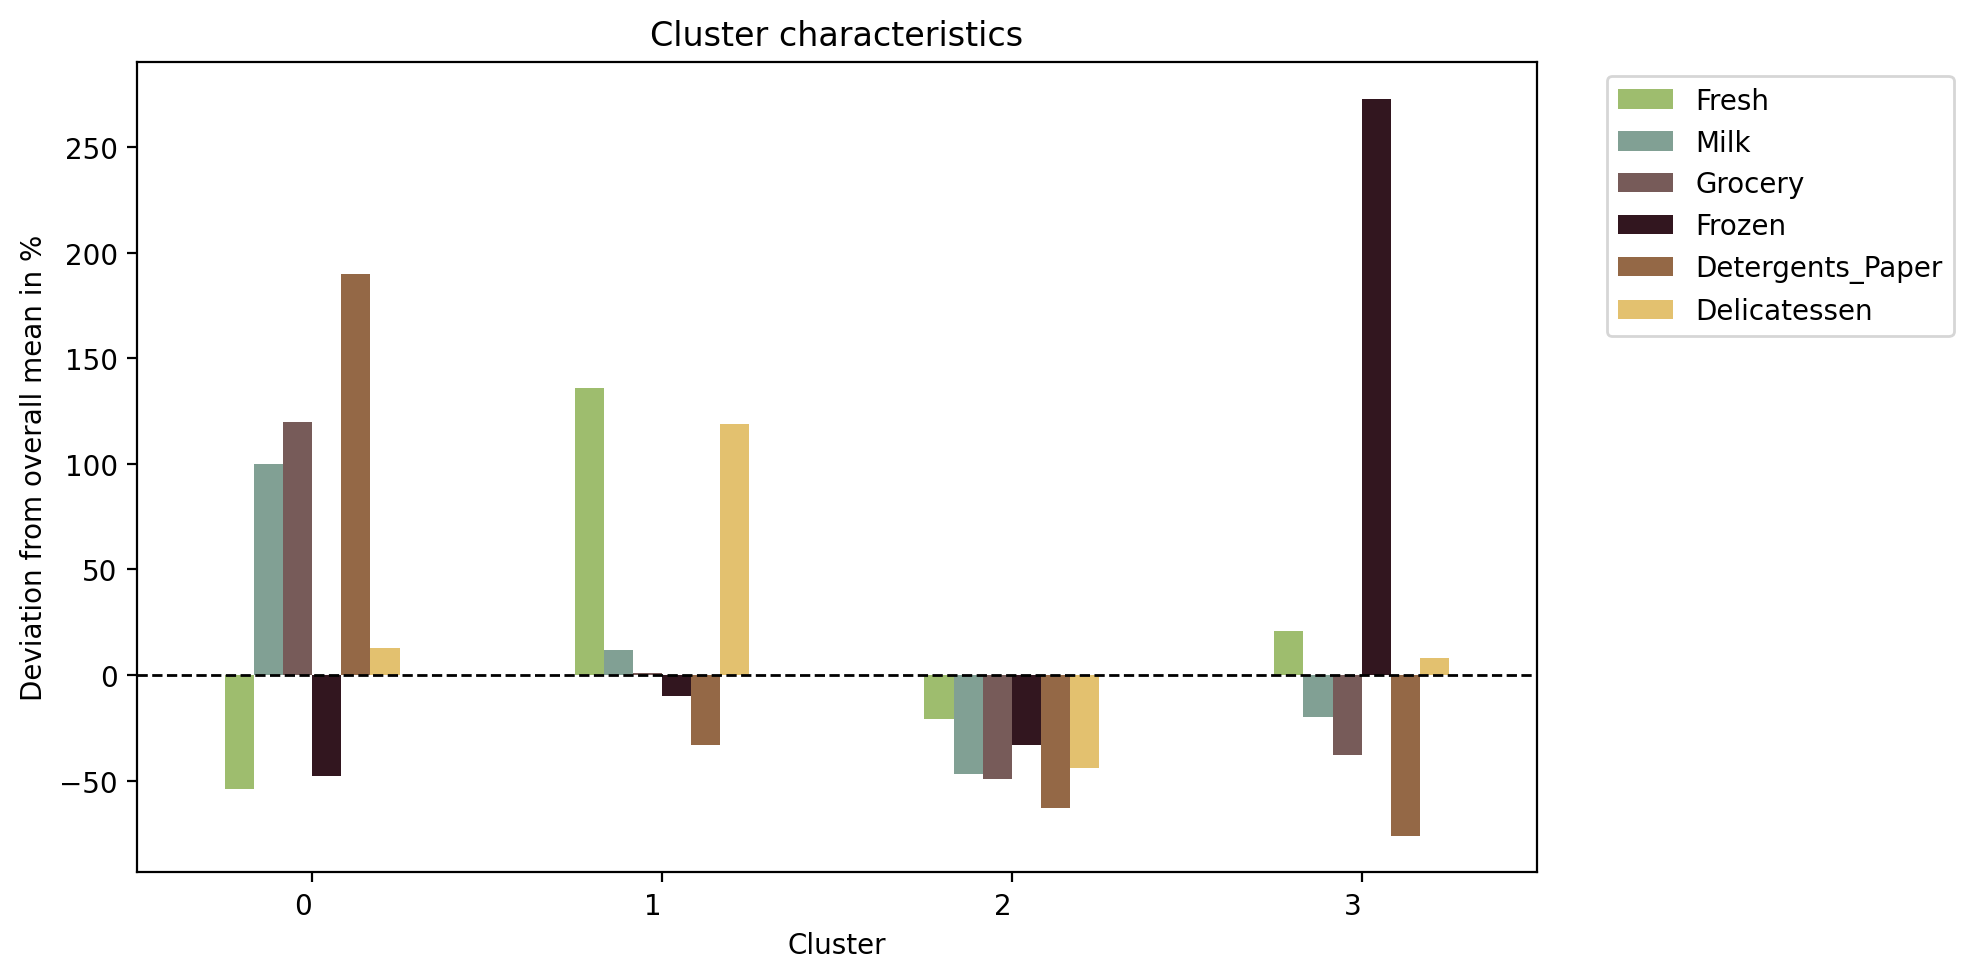

In [38]:
colors = ['#9EBD6E','#81a094','#775b59','#32161f', '#946846', '#E3C16F', '#fe938c', '#E6B89C','#EAD2AC',
          '#DE9E36', '#4281A4','#37323E','#95818D'
         ]

fig = plt.figure(figsize=(10,5), dpi=200)
X_dev_rel.T.plot(kind='bar', 
                       ax=fig.add_subplot(), 
                       title="Cluster characteristics", 
                       color=colors,
                       xlabel="Cluster",
                       ylabel="Deviation from overall mean in %"
                      )
plt.axhline(y=0, linewidth=1, ls='--', color='black')
plt.legend(bbox_to_anchor=(1.04,1))
fig.autofmt_xdate(rotation=0)
plt.tight_layout()
plt.show()

Discussion: Can we add region and channel to our clustersinterpretation? How? 